In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [30]:
original = pd.read_csv("../data/original (3).csv")
final_df = pd.read_csv("../data/original (4).csv")

## 2. What are the key factors influencing customer engagement with our marketing campaigns?
### Analyze historical campaign data to identify main drivers of engagement.

In [33]:
# merging final_df and original
# common columnns:
cols = ['CLIENTNUM', 'Income_Category', 'No_of_product', 'Total_Trans_Amt', 'Total_Trans_Count']
original = original.merge(final_df, on = cols, how = 'inner')

In [35]:
outcome_counts = original['Outcome'].value_counts(normalize = True) * 100

success_percentage = outcome_counts.get(1, 0)
failure_percentage = outcome_counts.get(0, 0)

# Display the percentages
print(f"Success Rate: {success_percentage:.2f}%")
print(f"Failure Rate: {failure_percentage:.2f}%")

Success Rate: 20.76%
Failure Rate: 79.24%


In [37]:
ori = original.copy()
cols_to_std = ['Duration_of_Contact', 'Num_of_Contacts_Made', 'Outcome']
ori[cols_to_std] = (ori[cols_to_std] - ori[cols_to_std].mean()) / ori[cols_to_std].std()
ori[['Duration_of_Contact', 'Num_of_Contacts_Made', 'Outcome']].corr()

,Duration_of_Contact,Num_of_Contacts_Made,Outcome
Duration_of_Contact,1.000000,0.417894,0.210033
Num_of_Contacts_Made,0.417894,1.000000,0.311240
Outcome,0.210033,0.311240,1.000000


The correlation matrix does not show high correlation between Outcome and any other variable. The highest positive correlation is between Outcome and Number of Contacts Made.

All the correlations are positive which means an increase in the duration of the contact or number of contacts made could result in an increase in outcome.

The reasons why the correlations are so low is because the number of successful campaigns is low.

Lets observe the correlation with other variables.

In [40]:
# observing correlation of selected columns & standardising numerical variables
# standardising numerical columns
num_cols_to_std = ['Customer_Age', 'Month_with_bank', 'No_of_product', 'Credit_Limit', 'Total_Trans_Amt'
                   , 'Total_Trans_Count', 'Savings', 'Credit Score'
                   , 'Balance', 'PaymentMethod'
                   , 'Transaction_Behavior', 'Banking_Behavior', 'Outcome']
ori[num_cols_to_std] = (ori[num_cols_to_std] - ori[num_cols_to_std].mean()) / ori[num_cols_to_std].std()

# One-hot encoding the categorical columns
ori = pd.get_dummies(ori, columns=['Education_Level', 'Income_Category', 'Card_Category'], drop_first=True)

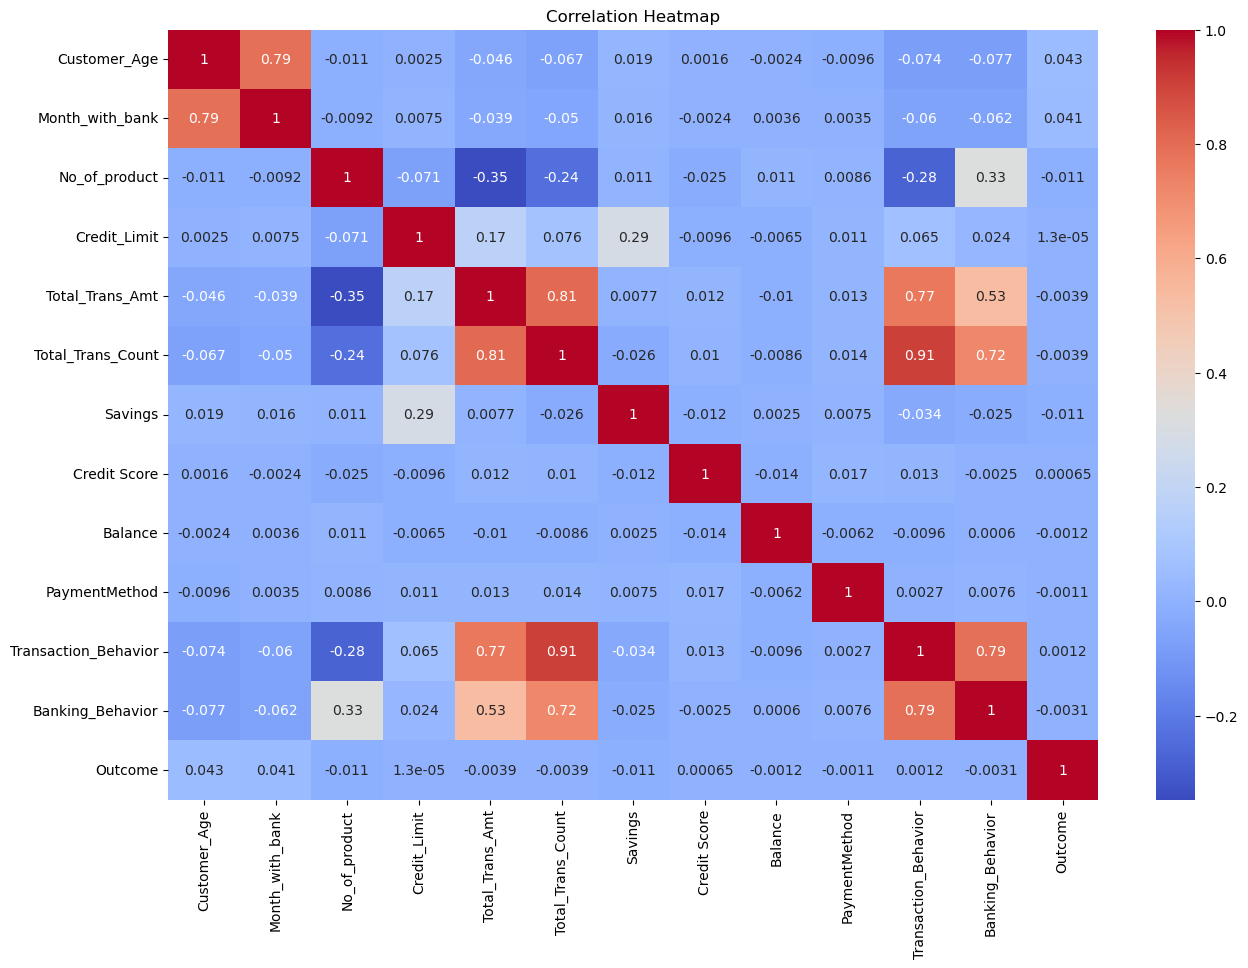

In [42]:
# Correlation Heatmap
plt.figure(figsize=(15,10))
sns.heatmap(ori[num_cols_to_std].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Outcome does not have high correlation with most of the other variables. The highest positive correlation is with `Customer_Age`, followed by the `Month_with_bank`. This means that the campaign effectivness increases when targetting this campaign to older people.

In conclusion, correlation is not useful in finding the main drivers of engagement.

In [45]:
X = ori[['Last_Contacted', 'Num_of_Contacts_Made', 'Months_Inactive_12_mon', 'Customer_Age', 
         'Total_Trans_Count', 'Total_Trans_Amt', 'Savings', 'Credit Score', 
         'Outstanding Loans', 'Balance'] + 
        [col for col in ori.columns if 'Education_Level_' in col or 
                                       'Income_Category_' in col or 
                                       'Card_Category_' in col]]

y = ori['Outcome']
y = (y >= 1).astype(int)

# splitting the data into training and test
## training data size: 80%; test data size: 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fitting the model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=1)

In [47]:
# Importance
importances = rf_model.feature_importances_
impt = pd.DataFrame(importances, index = X.columns, columns = ["Importance"]).sort_values("Importance", ascending = False)
impt

,Importance
Num_of_Contacts_Made,0.124018
Credit Score,0.091993
Outstanding Loans,0.090510
Customer_Age,0.090388
Total_Trans_Amt,0.089593
Balance,0.089093
Last_Contacted,0.087583
Total_Trans_Count,0.082038
Savings,0.081345
Education_Level_Unknown,0.049305


In [63]:
# removing the features that are not as important
X = ori[['Last_Contacted', 'Num_of_Contacts_Made', 'Customer_Age', 
         'Total_Trans_Count', 'Total_Trans_Amt', 'Savings', 'Credit Score', 
         'Outstanding Loans', 'Balance']]

y = ori['Outcome']
y = (y >= 1).astype(int)

# splitting the data into training and test
## training data size: 80%; test data size: 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fitting the model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=1)

In [64]:
# Importance
importances = rf_model.feature_importances_
impt = pd.DataFrame(importances, index = X.columns, columns = ["Importance"]).sort_values("Importance", ascending = False)
impt

,Importance
Num_of_Contacts_Made,0.149167
Last_Contacted,0.113654
Credit Score,0.113520
Outstanding Loans,0.112068
Total_Trans_Amt,0.111313
Balance,0.110541
Savings,0.097748
Customer_Age,0.097690
Total_Trans_Count,0.094299


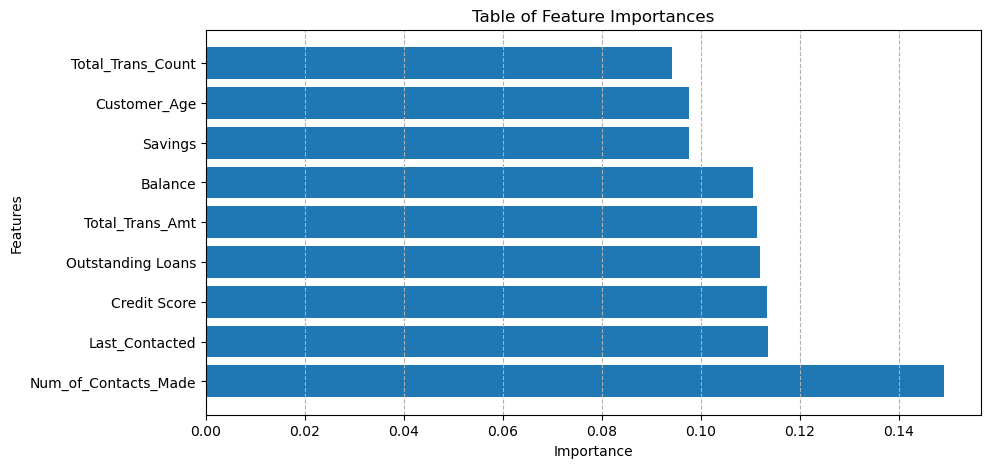

In [67]:
# Plotting the feature importances
plt.figure(figsize = (10, 5))
plt.title("Table of Feature Importances")
plt.barh(impt.index, impt["Importance"], align = "center")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(axis = 'x', linestyle = '--', alpha = 1)
plt.show()

- `Number_of_Contacts_Made` (0.149167) is the most important features in this list.
- `Last_Contacted` (0.113654), `Credit Score` (0.113520), `Outstanding Loans` (0.112068), `Total_Trans_Amt` (0.111313) and `Balance` (0.110541) follow, indicating moderate importance.
- The other features are less important features but might still play a role.

This suggests that the campaign should focus on contacting customers more and more often. Furthermore, they should also target customers with higher credit score, outstanding loans and those who have more money in the bank.

### Propose metrics for tracking campaign effectiveness over time

##### Key Factors Influencing Customer Engagement
1) Customer Segmentation:
    - Digital Engagement Level: Customers who are highly digitally engaged (Segment 1) are more likely to respond positively to digital marketing campaigns through channels like emails, social media, or mobile apps. Low-engagement customers (Segment 3) might prefer more traditional outreach like direct mail.
    - Transaction History: High spenders/frequent users (Segment 4) are likely to engage more with promotions related to exclusive offers, loyalty programs, or high-end products. On the other hand, low spenders (Segment 6) might be motivated by discounts or cost-saving opportunities.
    - Financial Status: Customers with high financial standing (Segment 10) might be drawn to campaigns promoting investment opportunities, premium accounts, or wealth management services. Low financial standing customers (Segment 12) may engage more with campaigns focused on debt management, credit improvement, or lower-cost products.

2) Personalization:
    - Personalization is crucial across all segments. The more tailored a campaign is to a customer’s habits, needs, and preferences, the higher the likelihood of engagement. For instance, using customer data to send offers relevant to their transaction behavior, product usage, or financial status can greatly increase engagement.

3) Communication Channel:
    - Digital engagement levels directly influence the preferred channels for communication. Highly digitally engaged customers are more responsive to email, social media, or app notifications, while others may prefer direct mail or phone calls. 


##### Proposed Metrics for Tracking Campaign Effectiveness
1) Engagement Rate:
    - Tracks the overall interaction with campaigns (e.g., email opens, clicks). This is a key indicator of initial interest across all customer segments.
2) Conversion Rate:
    - Measures the percentage of customers who complete the desired action (e.g., purchase, sign-up), giving direct insight into campaign success.
3) Customer Lifetime Value (CLV):
    - Helps track long-term profitability and how successful campaigns are in retaining and increasing the value of customers over time.
4) Return on Marketing Investment (ROMI):
    - Shows the financial impact of campaigns by comparing revenue generated to campaign costs, ensuring resources are allocated efficiently.

In [73]:
original.to_csv('../data/original (5).csv', index=False)